In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings

import numpy as np
import matplotlib.pyplot as plt
from agentic_energy.milp.milp_mcp_server import records_to_arrays, solve_daily_milp
from agentic_energy.data_loader import EnergyDataLoader, BatteryDataLoader
from agentic_energy.schemas import BatteryParams, DayInputs, EnergyDataRecord, SolveFromRecordsRequest

2025-11-18 22:44:54.077 | DEBUG    | agentics.core.llm_connections:<module>:121 - AGENTICS is connecting to the following LLM API providers:
2025-11-18 22:44:54.078 | DEBUG    | agentics.core.llm_connections:<module>:129 - 0 - Gemini
2025-11-18 22:44:54.078 | DEBUG    | agentics.core.llm_connections:<module>:133 - 1 - OpenAI
2025-11-18 22:44:54.078 | DEBUG    | agentics.core.llm_connections:<module>:135 - Please add API keys in .env file to add or disconnect providers.
2025-11-18 22:44:54.087 | DEBUG    | agentics.core.llm_connections:get_llm_provider:29 - No LLM provider specified. Using the first available provider.
2025-11-18 22:44:54.087 | DEBUG    | agentics.core.llm_connections:get_llm_provider:31 - Available LLM providers: ['gemini', 'openai']. Using 'gemini'


In [2]:
italy_obj = EnergyDataLoader(region="ITALY")
italy_data = italy_obj.load_region_data()

2025-11-18 22:44:55.186 | DEBUG    | agentics.core.agentics:from_csv:312 - Importing Agentics of type EnergyDataRecord from CSV /Users/millendroy/Projects/Agentic_Energy/Agentics_for_EnergyArbitrage_Battery/energy_arbitrage/agentic_energy/data/Italy_data_actual.csv


In [3]:
italy_data[0]

EnergyDataRecord(timestamps='2018-01-01 00:00:00', prices=45.82, consumption=22.98, year=None, region='ITALY', decisions=None)

In [4]:
italy_data[0].timestamps

'2018-01-01 00:00:00'

In [5]:
stats= await EnergyDataLoader.get_summary_stats_from_ag(italy_data)
print(stats.pretty_print())

Atype : <class 'agentic_energy.schemas.SummaryStats'>
region: ITALY
total_records: 17518
date_range:
  start: '2018-01-01 00:00:00'
  end: '2019-12-31 23:00:00'
prices:
  count: 17518
  min: 1.0
  max: 159.4
  avg: 56.81830574266469
  median: 55.99
  p25: 46.662499999999994
  p75: 66.13
  std: 14.514075376488504
  var: 210.6583840343899
consumption:
  count: 17518
  min: 18.85
  max: 50.31
  avg: 33.148212124671765
  median: 32.65
  p25: 26.96
  p75: 39.32
  std: 6.92811417513687
  var: 47.998766023732436




In [6]:
from datetime import datetime, timedelta
timedelta = datetime.strptime(stats.states[0].date_range.end, "%Y-%m-%d %H:%M:%S") - datetime.strptime(stats.states[0].date_range.start, "%Y-%m-%d %H:%M:%S")
days = timedelta.days + 1
days

730

In [7]:
# from datetime import datetime
# START_DATE = "2016-01-01"
# END_DATE = "2021-12-31"
# italy_data =  await italy_obj.get_filtered_data(START_DATE, END_DATE)
# stats = await EnergyDataLoader.get_summary_stats_from_ag(italy_data)
# timedelta = datetime.strptime(stats.states[0].date_range.end, "%Y-%m-%d %H:%M:%S") - datetime.strptime(stats.states[0].date_range.start, "%Y-%m-%d %H:%M:%S")
# days = timedelta.days + 1
# print(days)

In [8]:
0.08*12

0.96

In [9]:
italy_data[0], italy_data[-1]

(EnergyDataRecord(timestamps='2018-01-01 00:00:00', prices=45.82, consumption=22.98, year=None, region='ITALY', decisions=None),
 EnergyDataRecord(timestamps='2019-12-31 23:00:00', prices=42.3, consumption=25.4, year=None, region='ITALY', decisions=None))

In [10]:
italy_data = await italy_obj.get_filtered_data("2018-01-01", "2018-01-02")

In [11]:
batt = BatteryDataLoader(
    load_stats={
        "p25":stats.states[0].consumption.p25,
        "p75":stats.states[0].consumption.p75
    },
    duration_hours=4,
    soc_init=0.5,
    soc_min=0.0,
    soc_max=1.0,
    eta_c = 0.95,
    eta_d = 0.95,
    soc_target=0.5,
)
batterydetails = batt.compute_battery_params()
print(batt.summary())

{'Capacity (MWh)': 49.44, 'Charge Power (MW)': 12.36, 'Discharge Power (MW)': 12.36, 'Efficiency (Charge/Discharge)': (0.95, 0.95), 'Duration (hours)': 4}


In [12]:
# capacity = 1.0  # MWh
# batterydetails = BatteryParams(
#     capacity_MWh=capacity,   # 4-hour energy at 100 MW power: good for diurnal spreads
#     soc_init=0.50,        # neutral start
#     soc_min=0.0,         # keep 10% buffer for longevity + contingency
#     soc_max=1.0,         # avoid top-of-charge stress
#     cmax_MW=capacity/4,        # 4-hour duration (capacity/4)
#     dmax_MW=capacity/4,        # symmetric charge/discharge
#     eta_c=0.95,           # ~92% round-trip when paired with eta_d
#     eta_d=0.95,
#     soc_target=0.50       # keep headroom to buy when prices dip; adjust by time-of-day policy
# )

In [13]:
# now have a for loop to run milp on each day
result = []
day_info =[]
decision_list = []
soc_list =[]
for i in range(len(italy_data)//24):
    print(f"Solving day {i+1} of {len(italy_data)//24}")
    records = SolveFromRecordsRequest(
        battery=batterydetails,
        records=italy_data[i*24:(i+1)*24],
        dt_hours=1.0,
        allow_export=True,
        solver = None,
        solver_opts = None
    )

    prices, demand = records_to_arrays(records.records)
    day = DayInputs(
        prices_buy=prices,
        demand_MW=demand,
        prices_sell=prices,
        allow_export=records.allow_export,
        dt_hours=records.dt_hours
    )
    day_info.append(day)
    res = solve_daily_milp(records.battery, day, records.solver, records.solver_opts)
    result.append(res)
    decision_list+=res.decision
    batterydetails.soc_init=res.soc[-1]
    soc_list+=res.soc[:-1]


Solving day 1 of 2
Set parameter WLSAccessID


[11/18/25 22:45:04] INFO     Set parameter WLSAccessID                                           ]8;id=949803;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=779718;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\

Set parameter WLSSecret


                    INFO     Set parameter WLSSecret                                             ]8;id=284583;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=560562;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\

Set parameter LicenseID to value 2718037


                    INFO     Set parameter LicenseID to value 2718037                            ]8;id=420166;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=409730;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\

Academic license 2718037 - for non-commercial use only - registered to mi___@columbia.edu


                    INFO     Academic license 2718037 - for non-commercial use only - registered ]8;id=607637;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=284924;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\
                             to mi___@columbia.edu                                                                 

Solving day 2 of 2


In [14]:
len(result)

2

In [15]:
result[0].discharge_MW

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 9.887999999999998,
 12.36,
 12.36,
 12.36,
 0.0,
 0.0,
 0.0,
 0.0]

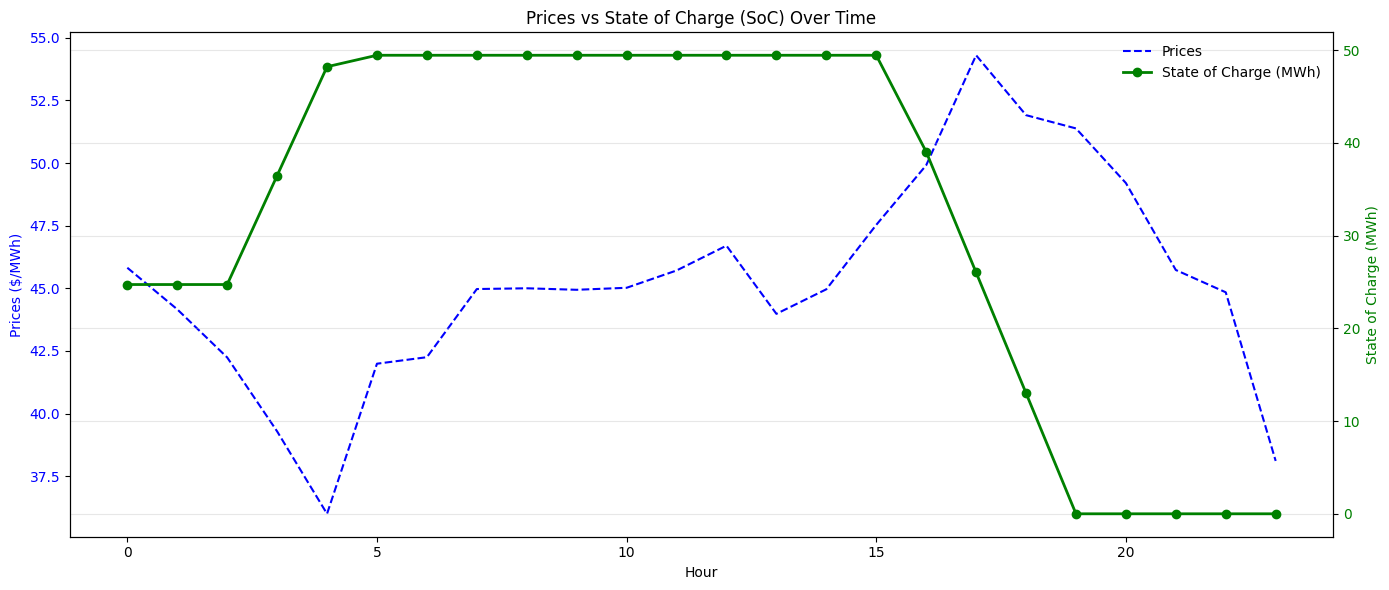

In [16]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, day_info[0].prices_buy, '--b', label='Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(result[0].soc[1:]) * batterydetails.capacity_MWh,
         '-og', label='State of Charge (MWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (MWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [17]:
plt.rcParams.update({
    "font.size": 16,          # base font size
    "axes.labelsize": 18,     # x/y label size
    "axes.titlesize": 20,     # title size
    "xtick.labelsize": 14,    # tick size
    "ytick.labelsize": 14,
    "legend.fontsize": 16,    # legend text size
    "font.weight": "bold",    # make all text bold
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
})

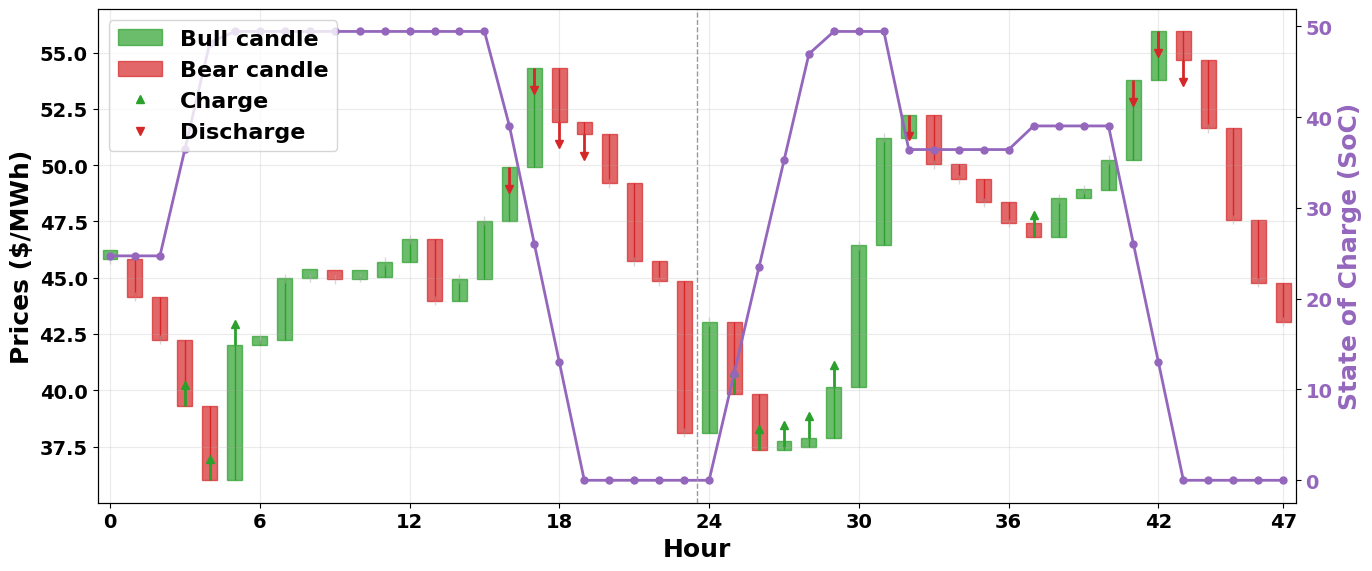

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_candles_with_soc(
    prices,                      # shape (24,) or (T,)
    soc,                         # SoC in [0,1] or MWh; shape (T,)
    *,
    capacity_MWh=None,           # if soc is [0,1] give capacity to convert on right axis
    actions=None,                # optional: array in [-1,1] (+charge, -discharge)
    soc_is_fraction=True,        # set False if soc already in MWh
    title="",
    candle_width=0.6,
    wick_width=0.1,
    tick_scale=0.8               # length of action stems in price units
):
    """
    Candles:
      open = price[t-1], close = price[t], high/low = max/min(open,close)
    Decision ticks:
      charge (a>0): green stem upward from price[t]
      discharge (a<0): red stem downward from price[t]
      neutral: no stem (or tiny gray nub)
    """

    prices = np.asarray(prices).astype(float)
    T = len(prices)
    hours = np.arange(T)

    # ----- derive open/close/high/low from the hourly series -----
    opens  = np.concatenate([[prices[0]], prices[:-1]])
    closes = prices
    highs  = np.maximum(opens, closes)
    lows   = np.minimum(opens, closes)

    # a small wick so candles are visible even if open==close
    eps = 1e-6
    highs = np.maximum(highs, lows + eps)

    # ----- actions (charge/discharge) -----
    if actions is None:
        # If no explicit actions, infer sign from SoC change:
        # positive delta SoC → charging; negative → discharging.
        soc_arr = np.asarray(soc, dtype=float)
        # align length to T
        if len(soc_arr) != T:
            # if user passed soc with 1 extra initial point, drop the first
            if len(soc_arr) == T + 1:
                soc_arr = soc_arr[1:]
            else:
                raise ValueError("soc length must be T or T+1 to infer actions.")
        dsoc = np.diff(soc_arr, prepend=soc_arr[0])
        actions = np.sign(dsoc)  # +1 charge, -1 discharge, 0 hold
    else:
        actions = np.asarray(actions, dtype=float)
        if len(actions) != T:
            raise ValueError("actions must have same length as prices.")

    # ----- plotting -----
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Candles
    for t in range(T):
        o, c, h, l = opens[t], closes[t], highs[t], lows[t]
        color = 'tab:green' if c >= o else 'tab:red'

        # wick
        ax1.vlines(t, l, h, linewidth=1, color=color)

        # body
        y = min(o, c)
        height = abs(c - o)
        # ensure visible body
        if height < (0.02 * np.ptp(prices) + 1e-9):
            height = 0.02 * np.ptp(prices) + 1e-9
        rect = Rectangle((t - candle_width/2, y), candle_width, height,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax1.add_patch(rect)

    # Decision ticks (stems from the CLOSE price)
    # Pick a tick length relative to the price range
    pr = np.ptp(prices) if np.ptp(prices) > 0 else 1.0
    L = tick_scale * 0.06 * pr

    for t in range(T):
        p = closes[t]
        a = actions[t]
        if a > 0:      # charge → green stem up
            ax1.vlines(t, p, p + L, linewidth=2, color='tab:green')
            ax1.plot([t], [p + L], marker='^', ms=6, color='tab:green')
        elif a < 0:    # discharge → red stem down
            ax1.vlines(t, p - L, p, linewidth=2, color='tab:red')
            ax1.plot([t], [p - L], marker='v', ms=6, color='tab:red')
        else:
            # optional small gray nub to indicate "hold"
            ax1.vlines(t, p - 0.01*pr, p + 0.01*pr, linewidth=1, color='0.7', alpha=0.5)

    # Axis styling for prices
    ax1.set_xlim(-0.5, T - 0.5)
    ax1.set_xticks(hours)
    ax1.set_xlabel("Hour")
    ax1.set_ylabel("Prices ($/MWh)")
    ax1.grid(alpha=0.25)

    # Secondary axis for SoC
    ax2 = ax1.twinx()
    soc_arr = np.asarray(soc, dtype=float)
    if len(soc_arr) == T + 1:   # many envs store soc[0..T]
        soc_arr = soc_arr[1:]
    if soc_is_fraction and capacity_MWh is not None:
        soc_plot = soc_arr * capacity_MWh
        ax2.set_ylabel("State of Charge (SoC)",  color='tab:purple')
    else:
        soc_plot = soc_arr
        ax2.set_ylabel("State of Charge (SoC)", color='tab:purple')

    ax2.plot(hours, soc_plot, '-o', linewidth=2, markersize=5, label="SoC", color='tab:purple')
    ax2.tick_params(axis='y', labelcolor='tab:purple')

    # Legends
    price_proxy_up = Rectangle((0,0),1,1, color='tab:green', alpha=0.7, label='Price ↑ (close≥open)')
    price_proxy_dn = Rectangle((0,0),1,1, color='tab:red',   alpha=0.7, label='Price ↓ (close<open)')
    stem_up_proxy  = plt.Line2D([0],[0], color='tab:green', marker='^', linestyle='None', label='Charge tick')
    stem_dn_proxy  = plt.Line2D([0],[0], color='tab:red',   marker='v', linestyle='None', label='Discharge tick')
    ax2.legend([price_proxy_up, price_proxy_dn, stem_up_proxy, stem_dn_proxy],
               ['Bull candle', 'Bear candle', 'Charge', 'Discharge'],
               loc='upper left', frameon=True)
    
    ax = plt.gca()
    ax.axvline(24 - 0.5, ls="--", lw=1, color="0.6")  # boundary between hour 23 and 24
    ax.set_xticks([0, 6, 12, 18, 24, 30, 36, 42, 47])
    ax.set_xticklabels(["0","6","12","18","24","30","36","42","47"])
    plt.draw()

    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---------- Example with your variables ----------
# prices = day_info[1].prices_buy                       # shape (24,)
# soc     = np.array(result[1].soc[1:])                 # length 24, SoC in [0,1]
# prices: hour-by-hour arrays (shape 24 each)
p1 = np.asarray(day_info[0].prices_buy, dtype=float)
p2 = np.asarray(day_info[1].prices_buy, dtype=float)
prices_48 = np.concatenate([p1, p2])                     # shape (48,)

# SoC: your result[i].soc likely has length 25 (t=0..24). We use [1:] to get 24 hourly points.
s1 = np.asarray(result[0].soc[1:], dtype=float)          # 24
s2 = np.asarray(result[1].soc[1:], dtype=float)          # 24
soc_48 = np.concatenate([s1, s2])                        # 48 (fraction 0..1)

# If you also have per-hour actions (in [-1,1]), you can concat them similarly:
# a1 = np.asarray(result[0].actions, dtype=float)
# a2 = np.asarray(result[1].actions, dtype=float)
# actions_48 = np.concatenate([a1, a2])

# ----- plot (the function from before) -----
plot_candles_with_soc(
    prices_48,
    soc_48,
    capacity_MWh=batterydetails.capacity_MWh,
    soc_is_fraction=True,
    # actions=actions_48,        # uncomment if you have explicit actions
)



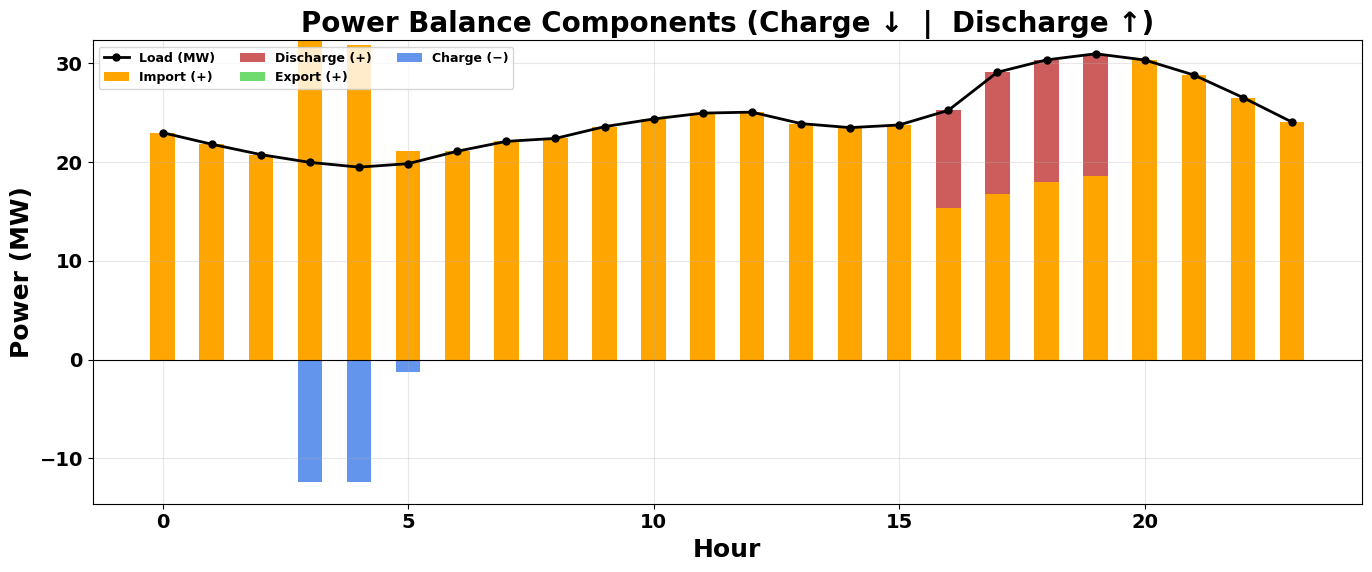

In [16]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)

# Data arrays
load = np.array(day_info[0].demand_MW)
charge = np.array(result[0].charge_MW)
discharge = np.array(result[0].discharge_MW)
import_MW = np.array(result[0].import_MW)
export_MW = np.array(result[0].export_MW) if getattr(day_info[0], "allow_export", False) else np.zeros_like(load)

# Flip battery convention for visualization
charge_vis = -charge       # show charge below 0
discharge_vis = discharge  # show discharge above 0

# ---------------------- PLOT ----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# --- positive side stacking (Import + Discharge + Export) ---
# import is base layer
ax.bar(hours, import_MW, width=0.5, color='orange', label='Import (+)')
# discharge stacked on top of import
ax.bar(hours, discharge_vis, width=0.5, bottom=import_MW, color='indianred', label='Discharge (+)')
# export stacked on top (for clear separation)
ax.bar(hours, export_MW, width=0.5, bottom=import_MW + discharge_vis, color='limegreen', alpha=0.7, label='Export (+)')

# --- negative side stacking (Charge only) ---
ax.bar(hours, charge_vis, width=0.5, color='cornflowerblue', label='Charge (−)')

# --- Load as line ---
ax.plot(hours, load, '-ok', linewidth=2, markersize=5, label='Load (MW)')

# Formatting
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Power (MW)")
ax.set_xlabel("Hour")
ax.set_title("Power Balance Components (Charge ↓  |  Discharge ↑)")
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [17]:
total_objective_value = 0
for day_result in result:
    total_objective_value += day_result.objective_cost
print(f"Total Objective Value over all days: ${total_objective_value:.2f} for {len(result)} days")

Total Objective Value over all days: $67517.00 for 2 days


In [18]:
result[0].objective_cost

25278.39562

In [19]:
# profit = day_info[0].prices_buy*discharge - day_info[0].prices_buy*charge
# print(profit.sum())

In [20]:
# len(decision_list)

In [21]:
# import pandas as pd
# italy_data = pd.read_csv("agentic_energy/data/ITALY_data.csv")
# italy_data.head()

In [22]:
# italy_data.shape

In [23]:
# 17496+24, 17496/24, len(soc_list)

In [24]:
# italy_data=italy_data.iloc[:len(decision_list)]
# soc_list = soc_list[:len(decision_list)]

In [25]:
# # I want to fill the decisions column in such a way that if soc_t > soc_t-1 then decision = 1 (charging)
# # if soc_t < soc_t-1 then decision = -1 (discharging)
# # if soc_t == soc_t-1 then decision = 0 (idle)
# italy_data["soc"] = soc_list
# italy_data['soc_prev'] = italy_data['soc'].shift(1)
# italy_data['decisions'] = 0  # Initialize with 0 (idle)
# italy_data.loc[italy_data['soc'] > italy_data['soc_prev'], 'decisions'] = 1   # Charging
# italy_data.loc[italy_data['soc'] < italy_data['soc_prev'], 'decisions'] = -1  # Discharging
# italy_data.loc[italy_data['soc'] == italy_data['soc_prev'], 'decisions'] = 0   # Idle



In [26]:
# italy_data.head()

In [27]:
# italy_data.to_csv("agentic_energy/data/ITALY_data_with_decisions.csv", index=False)

In [28]:
# # help me create a dataframe to csv to store the results that we see in the plots
# import pandas as pd
# df = pd.DataFrame()
# df["prices_actual"] = day_info[0].prices_buy
# df["prices_forecast"] = day_info[0].prices_buy_forecast
# df["actual_demand"] = day_info[0].demand_MW
# df["forecast_demand"] = day_info[0].demand_MW_forecast
# df["soc"] = result[0].soc[:-1]
# df["charge_MW"] = np.array(result[0].charge_MW)
# df["discharge_MW"] = np.array(result[0].discharge_MW)
# df["import_MW"] = np.array(result[0].import_MW)
# df["export_MW"] = np.array(result[0].export_MW)

# df.to_csv("MILP_output.csv", index = False)